In [1]:
import os 
import shutil
import pickle
import scipy 
import matplotlib.pyplot as plt
import numpy as np
from data_analysis import line_monotonic_detect, line_classify, Line_Type


import os 
import numpy as np 
import pickle
from matplotlib import pyplot as plt
import matplotlib
import shutil
# import seaborn as sns
from traj_run import rho_ohmic, check_onestep
from typing import Any
from numpy import dtype, ndarray
import scipy
from scipy.optimize import curve_fit
from scipy.fft import fft, fftfreq
from scipy.interpolate import interp1d
# import pywt
from data_analysis import read_line, read_exp, read_omega, get_rho_array, translate_param, chunk_data, interp_dat, do_fft, \
    fft_analysis, func_gentor, draw_t_S, draw_w_S, draw_t_I,  wavelet_denoising, line_monotonic_detect, show_result_t_S, \
    show_fft_res, show_w_freqs, show_w_freqs1, get_data_of_dof, get_signal_freq, do_cft, get_signal_amp, read_job_parameter, \
    show_result_t_I, dof_name_gentor_S, dof_name_gentor_I, get_near_zero_timestamp, get_min_timestamp

from scipy.optimize import curve_fit

from traj_run import check_onestep

2024-10-22 16:47:12,398[INFO] Use NumPy as backend
2024-10-22 16:47:12,398[INFO] numpy random seed is 9012
2024-10-22 16:47:12,398[INFO] random seed is 1092
2024-10-22 16:47:12,400[INFO] Git Commit Hash: 58dcf253cd1f3ed76dea70b0d49c39751855b526
2024-10-22 16:47:12,400[INFO] use 64 bits


coherent dynamics, i.e. damped oscillatory behaviour with minima and maxima, 

incoherent dynamics, i.e. purely monotonic decay, and 

pseudo-coherent dynamics, i.e. a single minimum and subsequent decay into localization.

In [2]:
mother_folder = '/home/ansatz/data/comp/sbm/24_09_17'
lines = sorted([ s for s in os.listdir(mother_folder) if s.startswith('traj_s') ])
# xvgs = sorted([[ os.path.join(line, s) for s in os.listdir(os.path.join(mother_folder, line)) if s.endswith('_p.xvg') ][0]for line in lines])
print('-----')
nstpes = 200
line_dict = {}
for line in lines:
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line)
    pf = os.path.join(mother_folder, line)
    try:
        data_exp = read_exp(pf)
        line_dict[line] = data_exp
    except:
        print(f's:{s:.02f} alpha:{alpha:.02f}')

-----
s:0.05 alpha:0.80


In [3]:
s = 0.05
alpha = 0.5
key = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"

In [4]:
ori_data = line_dict[key]

In [5]:
filter_data = wavelet_denoising(ori_data)

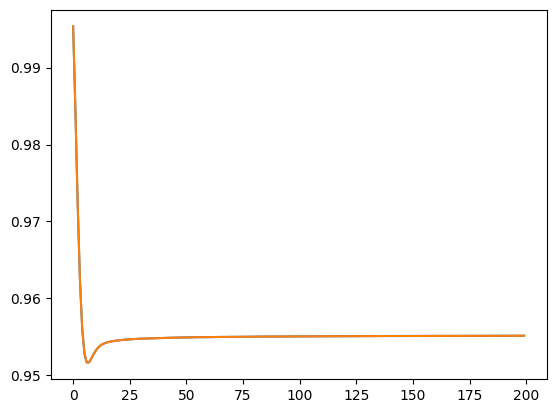

In [6]:
plt.plot(filter_data)

plt.plot(ori_data)
# plt.xlim(50,60)
# plt.ylim(0.954,0.956)

In [7]:
is_monotonic_results = line_monotonic_detect(filter_data)

In [8]:
is_monotonic_results

[1,
 3,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4]

In [9]:
sorted([1,2,3])

[1, 2, 3]

In [10]:
line_classify(filter_data)

[53] 1
[6] 1


<Line_Type.Oscillation: 2>

In [11]:
scipy.signal.argrelmax(filter_data)[0]

array([ 53,  57,  59,  63,  68,  72,  75,  77,  79,  82,  84,  87,  89,
        91,  96,  99, 101, 108, 112, 114, 119, 122, 124, 127, 130, 133,
       136, 142, 146, 148, 150, 156, 159, 163, 166, 169, 171, 174, 177,
       180, 183, 186, 188, 192, 194, 197])

In [12]:
scipy.signal.argrelmin(filter_data)[0]

array([  6,  54,  58,  60,  64,  69,  73,  76,  78,  80,  83,  85,  88,
        90,  92,  97, 100, 102, 109, 113, 115, 121, 123, 126, 129, 131,
       134, 137, 143, 147, 149, 152, 157, 160, 164, 167, 170, 172, 175,
       179, 182, 184, 187, 189, 193, 196, 198])

In [13]:
res = {}
other = []
for line_key in line_dict:
    s, alpha, Omega, omega_c, nmodes, bond_dims, td_method, rho_type = read_job_parameter(line_key)
    ori_data = line_dict[line_key]
    filter_data = wavelet_denoising(ori_data)
    type = line_classify(filter_data)
    if type != 0:
        res[(s, alpha)] = type
    else:
        print((s, alpha))
        other.append((s, alpha))

[54] 1
[27] 1
[169] 1
[12] 1
[135] 1
[10] 1
[82] 1
[9] 1
[87] 1
[8] 1
[54] 1
[7] 1
[53] 1
[6] 1
[50] 1
[6] 1
[51] 1
[6] 1
[48] 1
[5] 1
[45] 1
[5] 1
[33] 1
[5] 1
[32] 1
[4] 1
[23] 1
[4] 1
[28] 1
[4] 1
[55] 1
[28] 1
[186] 1
[12] 1
[159] 1
[11] 1
[121] 1
[9] 1
[91] 1
[8] 1
[67] 1
[7] 1
[67] 1
[7] 1
[60] 1
[6] 1
[44] 1
[6] 1
[40] 1
[5] 1
[34] 1
[5] 1
[36] 1
[5] 1
[30] 1
[5] 1
[38] 1
[4] 1
[29] 1
[4] 1
[26] 1
[4] 1
[57] 1
[29] 1
[187] 1
[12] 1
[154] 1
[10] 1
[94] 1
[9] 1
[83] 1
[8] 1
[61] 1
[7] 1
[65] 1
[7] 1
[46] 1
[6] 1
[53] 1
[6] 1
[44] 1
[5] 1
[38] 1
[5] 1
[34] 1
[5] 1
[41] 1
[4] 1
[30] 1
[4] 1
[32] 1
[4] 1
[ 59 119] 2
[30 90] 2
[152] 1
[11] 1
[108] 1
[10] 1
[103] 1
[8] 1
[96] 1
[8] 1
[64] 1
[7] 1
[65] 1
[6] 1
[47] 1
[6] 1
[39] 1
[6] 1
[42] 1
[5] 1
[39] 1
[5] 1
[32] 1
[5] 1
[32] 1
[4] 1
[36] 1
[4] 1
[ 61 122 178] 3
[ 31  93 160] 3
[192] 1
[12] 1
[139] 1
[10] 1
[113] 1
[9] 1
[96] 1
[8] 1
[72] 1
[7] 1
[54] 1
[7] 1
[52] 1
[6] 1
[45] 1
[6] 1
[44] 1
[5] 1
[38] 1
[5] 1
[41] 1
[5] 1
[33] 1
[5]

In [14]:
res

{(0.05, 0.05): <Line_Type.Oscillation: 2>,
 (0.05, 0.1): <Line_Type.One_Valley: 0.2>,
 (0.05, 0.15): <Line_Type.One_Valley: 0.2>,
 (0.05, 0.2): <Line_Type.One_Valley: 0.2>,
 (0.05, 0.25): <Line_Type.Oscillation: 2>,
 (0.05, 0.3): <Line_Type.Oscillation: 2>,
 (0.05, 0.35): <Line_Type.Oscillation: 2>,
 (0.05, 0.4): <Line_Type.Oscillation: 2>,
 (0.05, 0.45): <Line_Type.Oscillation: 2>,
 (0.05, 0.5): <Line_Type.Oscillation: 2>,
 (0.05, 0.55): <Line_Type.Oscillation: 2>,
 (0.05, 0.6): <Line_Type.Oscillation: 2>,
 (0.05, 0.65): <Line_Type.Oscillation: 2>,
 (0.05, 0.7): <Line_Type.Oscillation: 2>,
 (0.05, 0.75): <Line_Type.Oscillation: 2>,
 (0.05, 0.85): <Line_Type.Oscillation: 2>,
 (0.05, 0.9): <Line_Type.Oscillation: 2>,
 (0.05, 0.95): <Line_Type.Oscillation: 2>,
 (0.1, 0.05): <Line_Type.Oscillation: 2>,
 (0.1, 0.1): <Line_Type.One_Valley: 0.2>,
 (0.1, 0.15): <Line_Type.One_Valley: 0.2>,
 (0.1, 0.2): <Line_Type.One_Valley: 0.2>,
 (0.1, 0.25): <Line_Type.Oscillation: 2>,
 (0.1, 0.3): <Line_T

In [15]:
# coherent:  oscillatory
# incoherent: decay 
# pseudo-coherent: a single minimum and subsequent decay into localization 

In [16]:
job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"  ####################

In [17]:
incoherent_points  = sorted([key for key in res if res[key] == Line_Type.Decend ] )
# incoherent_points
len(incoherent_points)

30

In [18]:
coherent_points  = sorted([key for key in res if res[key] == Line_Type.Oscillation ] )
# coherent_points
len(coherent_points)

240

In [19]:
pseudo_coherent_points  = sorted([key for key in res if (res[key] == Line_Type.One_Valley or  res[key] ==Line_Type.Single_Minimum_And_Subsequent_Decay)] )
# 
# pseudo_coherent_points
len(pseudo_coherent_points)

330

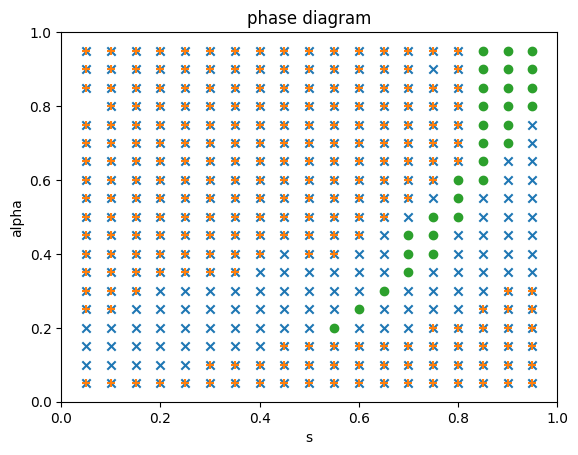

In [20]:
plt.xlabel('s')
plt.ylabel('alpha')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('phase diagram')
plt.scatter([key[0] for key in pseudo_coherent_points], [key[1] for key in pseudo_coherent_points], marker='x')
plt.scatter([key[0] for key in coherent_points], [key[1] for key in coherent_points], marker='+')
plt.scatter([key[0] for key in incoherent_points], [key[1] for key in incoherent_points], marker='o')

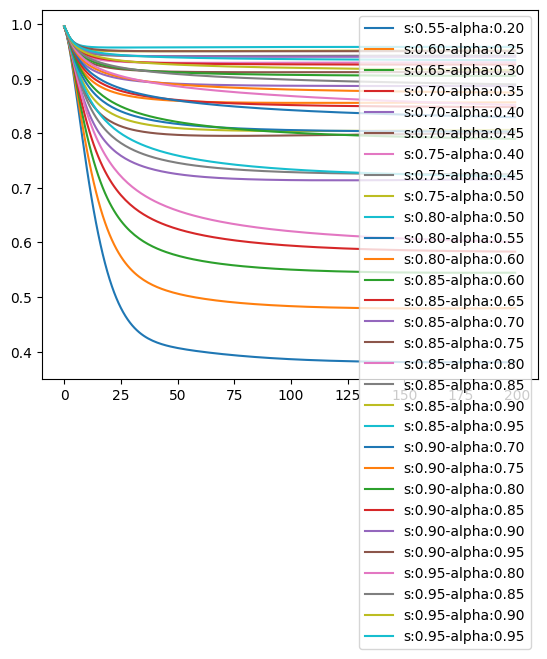

In [21]:
for key in incoherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    ori_data = line_dict[job_name]
    plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
    plt.legend()

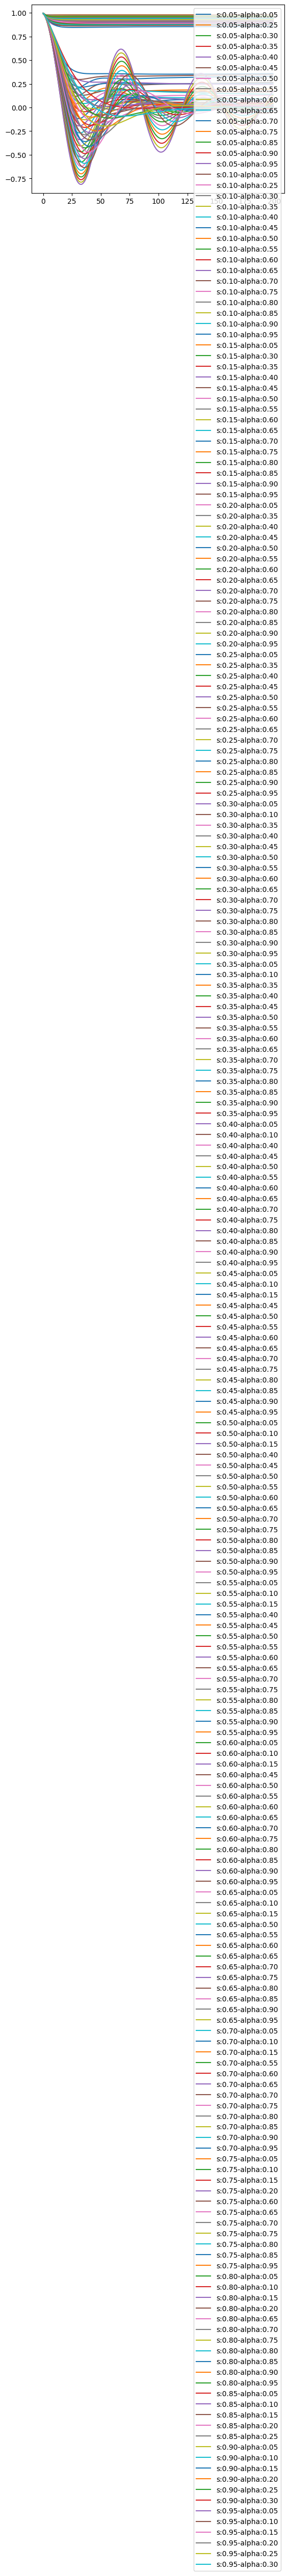

In [22]:
for key in coherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    ori_data = line_dict[job_name]
    plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
    plt.legend()

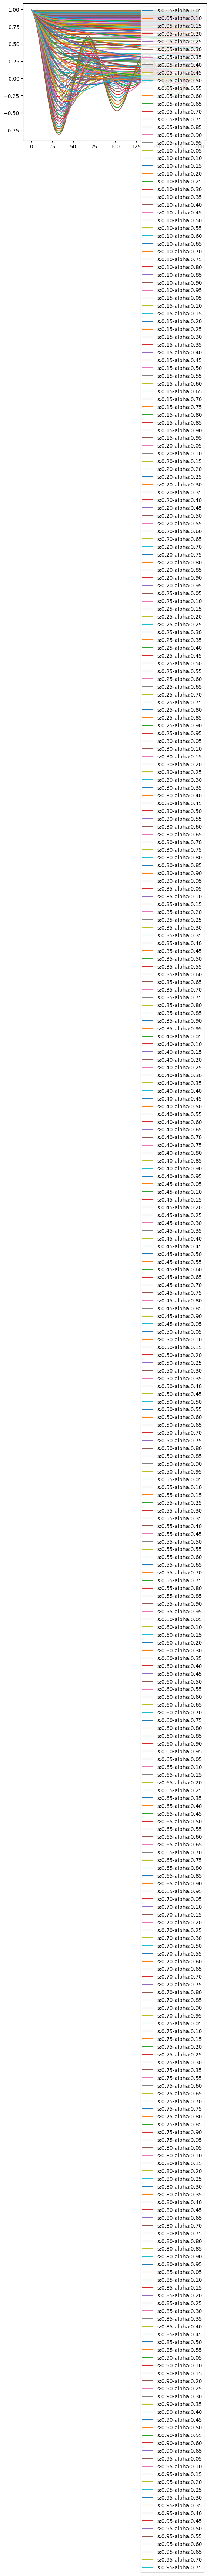

In [23]:
for key in pseudo_coherent_points:
    s, alpha = key
    job_name = f"traj_s{s:.2f}_alpha{alpha:.2f}_Omega{Omega}_omega_c{omega_c}_nmodes{nmodes}_bond_dims{bond_dims}_td_method_{td_method}_rho_type_{rho_type}"
    ori_data = line_dict[job_name]
    plt.plot(ori_data, label=f's:{s:.02f}-alpha:{alpha:.02f}')
    plt.legend()

In [24]:
# incoherent_points.append((0.9, 0.3))

# pseudo_coherent_points.append((0.2, 0.7))
# pseudo_coherent_points.append((0.2, 0.8))
# pseudo_coherent_points.append((0.4, 0.8))
# coherent_points.remove((0.2, 0.7))
# coherent_points.remove((0.2, 0.8))
# coherent_points.remove((0.4, 0.8))

# pseudo_coherent_points.remove((0.8, 0.2))
# pseudo_coherent_points.remove((0.9, 0.2))
# pseudo_coherent_points.remove((0.9, 0.3))
# incoherent_points.append((0.9, 0.3))
# coherent_points.append((0.8, 0.2))
# coherent_points.append((0.9, 0.2))

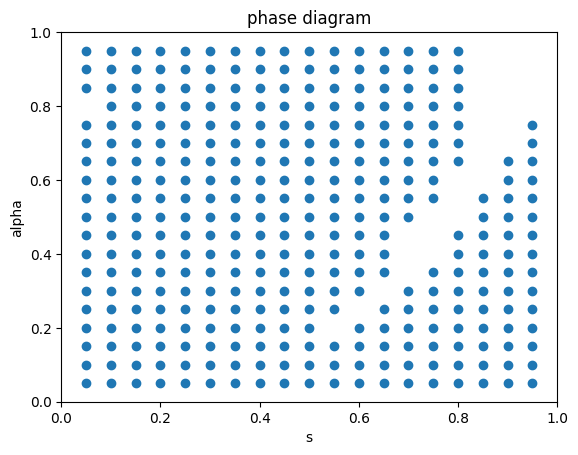

In [25]:
plt.xlabel('s')
plt.ylabel('alpha')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('phase diagram')
plt.scatter([s[0]for s in pseudo_coherent_points], [s[1]for s in pseudo_coherent_points])

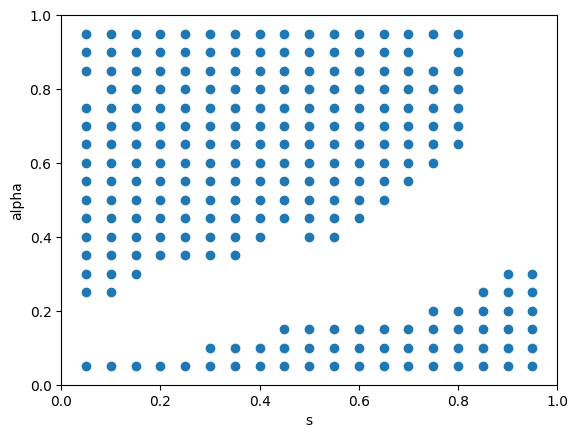

In [26]:
plt.xlabel('s')
plt.ylabel('alpha')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter([s[0]for s in coherent_points], [s[1]for s in coherent_points])

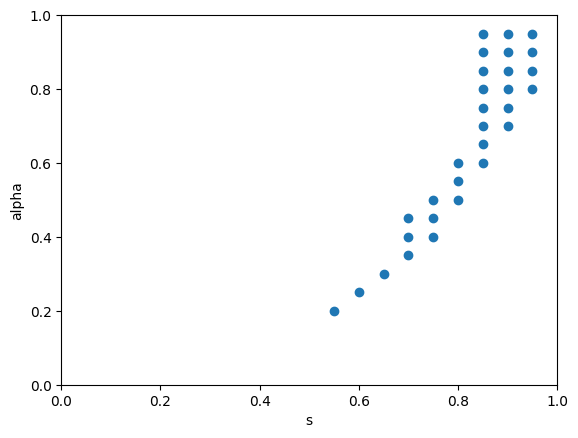

In [27]:
plt.xlabel('s')
plt.ylabel('alpha')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter([s[0]for s in incoherent_points], [s[1]for s in incoherent_points])